In [2]:
import numpy as np
import xbout
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, sys

In [56]:
path = r"C:\Users\mikek\OneDrive\Project\collab\tech\cases\hw3d\hw3d_base"
ds_original = xbout.load.open_boutdataset(
                datapath = os.path.join(path,"BOUT.dmp.*.nc"),
                inputfilepath = os.path.join(path, "BOUT.inp"),
                info = False,
                cache = False,
                keep_xboundaries=False,
                keep_yboundaries=False,
                # keep_zboundaries=False
                )

C:\Users\mikek\OneDrive\Project\python-packages\xBOUT\xbout\geometries.py:226: UserWarning: Size of toroidal domain as calculated from nz*dz (<xarray.DataArray 'dz' ()>
dask.array<sub, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>
Attributes:
    cell_location:  CELL_CENTRE
    direction_y:    Standard
    direction_z:    Average
    source:         Coordinates
    metadata:       {'BOUT_VERSION': 5.01, 'MXG': 2, 'MXSUB': 4, 'MYG': 2, 'M...
    options:        #\n# Hasegawa-Wakatani test case\n#\n\ntimestep = 1.0   #...
    geometry:        is not the same as 2pi*(ZMAX - ZMIN) (6.283185307179586): using value from dz
  warn(


# Input calculation
The below was assumed based on rough SOL conditions in MAST-U:
- T_0 = 50 [eV]
- n_0 = 1e19 [m^-3]
- B = 0.5 [T]

We can then calculate the electron cyclotron frequency:
omega_ce = eB / m_e = 8.79e11 [s^-1]

We now need the nu_ei term. The notes are inconsistent: in the Parallel current section, nu_ei is referred to as a friction due to collisions with ions, which is also consistent with the variable name. Later, in the Normalisation section, it's referred to as the electron collision frequency.

For now we assume the former is correct.
We calculate the ee collision time and frequency from Fitzpatrick (https://farside.ph.utexas.edu/teaching/plasma/lectures1/node35.html):
- tau_ee = 1.22e-6 [s]
- freq_ee = 1/tau_ei = 8.22e6 [s^-1]

Resistivity can be calculated as below (see any textbook with Braginskii parallel friction, thanks John Omotani):
- nu_ei = freq_ee * 0.51 = 4.11e6 [s^-1]

Finally, we arrive at our parameter alpha:
- alpha = omega_ce / nu_ei = 2.14e5 [-]


## Ben's original calc with electron-electron collisions
- Unfortunately in the original attempt at this, the bracket encompassing the entire numerator was missed

In [99]:
T0 = 50  # Plasma temperature [eV]
n0 = 1e19  # Plasma density [m^-3]
B = 0.5   # Magnetic field [T]
Mp = 1.6726219e-27 # Proton mass [kg]
Mi = Mp*2  # Ion mass of deuterium [kg]
Me = 9.1093837e-31 # Electron mass [kg]
qe = 1.60217662E-19 # electron charge [C] or [J ev^-1]
e0 = 8.854187817e-12 # Vacuum permittivity [F m^-1]

omega_ce = qe * B / Me

clog = abs(6.6 - 0.5 * np.log(n0) + 1.5*np.log(T0))   # Coulomb logarithm
tau_e = ( 6 * np.sqrt(2) * np.pi**(3/2) * e0**2 * np.sqrt(Me) * qe*T0**(3/2) ) / (clog * qe**4 * n0)
freq_e = 1/tau_e
nu_ei = freq_e * 0.51
alpha = omega_ce / nu_ei

print(f"Coulomb log: {clog:.2f}")
print(f"omega_ce: {omega_ce:.2e}")
print(f"ei friction nu_ei: {nu_ei:.2e}")
print(f"alpha parameter: {alpha:.2e}")

Coulomb log: 9.41
omega_ce: 8.79e+10
ei friction nu_ei: 1.58e-04
alpha parameter: 5.57e+14


# New calculation
- Now correctly considering e-i collisions as per notes instead of e-e collisions like above
- The answer doesn't really change

In [100]:
Z = 1
## From Hermes-3 manual: 
# https://hermes3.readthedocs.io/en/latest/components.html#collisions
## Originally from NRL formulary but converted to SI from CGS, hence different constants:
# https://library.psfc.mit.edu/catalog/online_pubs/NRL_FORMULARY_19.pdf
clog = 0
if T0 < 0.1 or n0 < 1e10:
    clog = 10   
elif T0*Me/Mi < T0 and T0 < 10*Z**2:
    clog = 30 - 0.5*np.log(n0) + 1.5*np.log(T0)
elif T0*Me/Mi < 10*Z**2 and 10*Z**2 < T0:    # <--------- This one for T0=50, n0=1e19
    clog = 31 - 0.5*np.log(n0) + np.log(T0)
elif T0 < T0*Me/Mi:
    clog = 23 - 0.5*np.log(n0) + 1.5*np.log(T0) - np.log(Z*Mi)

# Collision time from Fitzpatrick https://farside.ph.utexas.edu/teaching/plasma/lectures1/node35.html
tau_ei = ( 6 * np.sqrt(2) * np.pi**(3/2) * e0**2 * np.sqrt(Me) * qe*T0**(3/2) ) / (clog * qe**4 * n0)
freq_ei = 1/tau_ei   # Collision frequency
nu_ei = freq_e * 0.51   # Friction term
alpha = omega_ce / nu_ei
print(f"Coulomb log: {clog:.2f}")
print(f"omega_ce: {omega_ce:.2e}")
print(f"ei friction nu_ei: {nu_ei:.2e}")
print(f"alpha parameter: {alpha:.2e}")

Coulomb log: 13.04
omega_ce: 8.79e+10
ei friction nu_ei: 1.58e-04
alpha parameter: 5.57e+14


- Vorticity is described in Fundamenski 2007
- It's the vorticity of the electric drift
- It's defined as Omega = grad_P**2 phi

# Unnormalisation

### Normalisation factors and unnormalising outputs
- Density, temperature and magnetic field come from user choice
- They are then used to calculate the other factors

In [39]:
Nnorm = n0   # Density [m^-3]
Tnorm = T0   # Temperature [eV]
Omega_ci = qe * B / Mi   # Frequency [s^-1]
Cs0 = np.sqrt( (qe * Tnorm) / Mi)   # Speed [m s^-1]
rho_s0 = Cs0 / Omega_ci  # Distance [m]


ds["n"] *= Nnorm   # Density [m^-3]
ds["phi"] *= Tnorm   # Potential [V]
# ds["vort"] *= ???   # Vorticity [???]
ds["t"] *= (1/Omega_ci)    # Time [s]

## Unnormalise space and time

In [67]:
ds = ds_original.copy()

### Make X coordinate from dx (https://github.com/boutproject/xBOUT-examples/blob/master/hasegawa-wakatani/hasegawa-wakatani_example.ipynb)
dx = ds["dx"].isel(x=0).values

# Get rid of existing "x" coordinate, which is just the index values.
ds = ds.drop("x")

# Create a new coordinate, which is length in units of rho_s
ds = ds.assign_coords(x=np.arange(ds.sizes["x"])*dx[0])

### Unnormalise all spatial coordinates
# Note Xarray won't let you do it inplace, hence this method
ds = ds.assign_coords(x=ds["x"]*rho_s0)
ds = ds.assign_coords(y=ds["y"]*rho_s0)
ds = ds.assign_coords(z=ds["z"]*rho_s0)

### Unnormalise time
ds = ds.assign_coords(t=ds["t"]*(1/Omega_ci))

## Investigate convergence
- Presumably we can say we're converged once the fluctuation in outputs reaches a steady state

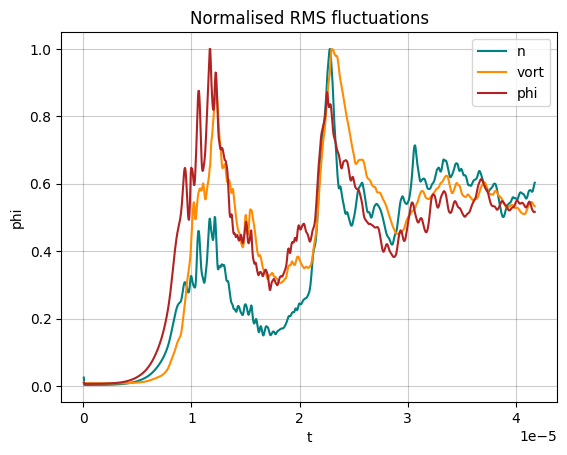

In [98]:
%matplotlib inline
### Calculate RMS of fluctuations

def get_scaled_rms(da):
    """
    Calculate root mean square of a DataArray
    """
    diff = da.diff("t")
    fractional_diff = diff 
    rms = np.sqrt((fractional_diff**2).mean(["x", "y", "z"]))
    return rms / rms.max()

### Plot
fig, ax = plt.subplots()
get_scaled_rms(ds["n"]).plot(ax = ax, label = "n", color = "teal")
get_scaled_rms(ds["vort"]).plot(ax = ax, label = "vort", color = "darkorange")
get_scaled_rms(ds["phi"]).plot(ax = ax, label = "phi", color = "firebrick")

ax.set_title("Normalised RMS fluctuations")
ax.grid(c = "k", alpha = 0.2)
ax.legend()

# Plots and animations

n data passed has 3 dimensions - will use animatplot.blocks.Pcolormesh()


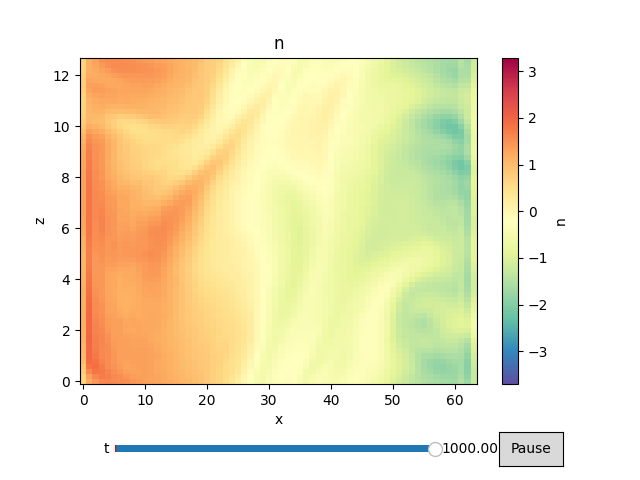

In [22]:
%matplotlib widget
plt.close("all")
ds.isel(y=8)["n"].bout.animate2D(fps = 30, cmap = "Spectral_r", 
                                    save_as=r"C:\Users\mikek\OneDrive\Project\collab\tech\cases\hw3d\hw3d_xz.gif"
                                    )

In [15]:
xbout.animate2D?

Object `xbout.animate2D` not found.


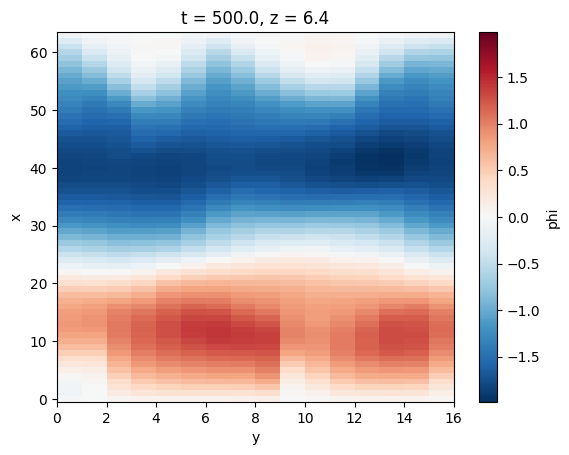

In [4]:
ds.isel(t=500, z = 32)["phi"].plot()